---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [1]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [2]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


In [41]:
labels

,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2
1,1,0,12088,Irrelevant,0
2,2,0,42931,Exact,2
3,3,0,2636,Exact,2
4,4,0,42923,Exact,2
...,...,...,...,...,...
233443,234010,478,15439,Partial,1
233444,234011,478,451,Partial,1
233445,234012,478,30764,Irrelevant,0
233446,234013,478,16796,Partial,1


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [45]:
# Copy your BM25 functions from Homework 3
import Stemmer
import string
from collections import Counter

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_bm25(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [4]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# YOUR CODE HERE
model_name = 'all-MiniLM-L6-v2'
model =  SentenceTransformer(model_name)

embs = model.encode(words, convert_to_numpy = True)

# Print the number of embeddings you generated and the dimension of the embeddings
print(f'Number of embeddings: {embs.shape[0]}')
print(f'The dimension of embeddings: {embs.shape[1]}')

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1068.06it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of embeddings: 5
The dimension of embeddings: 384


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [5]:
# Implement cosine similarity from scratch
def consine_similarity(a: np.array, b: np.array):
    sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return sim
# Create similarity matrix
sim_matrix_ls = []

for emb1 in embs:
    row = []
    for emb2 in embs:
        sim = consine_similarity(emb1, emb2)
        row.append(sim)
    sim_matrix_ls.append(row)

sim_matrix = np.array(sim_matrix_ls)

# Display as DataFrame
sim_matrix_df = pd.DataFrame(sim_matrix)
print(f'Similarity Matrix is:\n {sim_matrix_df}')

Similarity Matrix is:
           0         1         2         3         4
0  1.000000  0.588631  0.370622  0.189486  0.295712
1  0.588631  1.000000  0.337910  0.249521  0.341410
2  0.370622  0.337910  1.000000  0.380311  0.057740
3  0.189486  0.249521  0.380311  1.000000  0.125802
4  0.295712  0.341410  0.057740  0.125802  1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [15]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model
response = litellm.embedding(model = 'text-embedding-3-small', input = words)
openai_embs = np.array([output['embedding'] for output in response.data])

print(f'The embedding dimension for local model is: {embs.shape[1]}')
print(f'The embedding dimension for OpenAI text embedding model is {openai_embs.shape[1]}')

The embedding dimension for local model is: 384
The embedding dimension for OpenAI text embedding model is 1536


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [17]:
# Get a consistent sample
product_sample = products.sample(n = 5000, random_state = 42).copy()

In [23]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# YOUR CODE HERE
product_sample['combined_text'] = product_sample['product_name'].fillna('').astype(str) + ' ' + product_sample['product_class'].fillna('').astype(str)
texts = product_sample['combined_text'].tolist()
embs_product = model.encode(texts, convert_to_numpy = True)

### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [27]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match
np.save('../temp/hw4_embeddings.npy', embs_product)
product_sample.to_csv('../temp/hw4_products.csv', index = False)

embs_product_load = np.load('../temp/hw4_embeddings.npy')
product_sample_load = pd.read_csv('../temp/hw4_products.csv')

product_sample = product_sample.reset_index(drop = True)
product_sample_load = product_sample_load.reset_index(drop = True)

print('Embeddings equal:', np.allclose(embs_product, embs_product_load))
print('Products same combined_text:', product_sample['combined_text'].equals(product_sample_load['combined_text']))

Embeddings equal: True
Products same combined_text: True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [30]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
import tiktoken

encoder = tiktoken.encoding_for_model('text-embedding-3-small')

sample_tokens = product_sample['combined_text'].apply(lambda x: len(encoder.encode(x)))
sample_token_num = sample_tokens.sum()
avg_product_token = sample_token_num / len(sample_tokens)

total_cost = products.shape[0] * avg_product_token * 0.02 / 1000000
print(f'Total cost is {total_cost}')

Total cost is 0.011191682151999999


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [35]:
# Implement batch cosine similarity for efficiency
def batch_cosine_similarity(q_emb, v_embs):
    
    q_norm = q_emb / np.linalg.norm(q_emb)
    v_norms = v_embs / np.linalg.norm(v_embs, axis = 1, keepdims = True)
    scores = v_norms @ q_norm

    return scores

In [36]:
# Implement semantic search
def semantic_search(query, model, product_embeddings, products_df, k = 10):
    q_emb = model.encode(query, convert_to_numpy = True)

    similarities = batch_cosine_similarity(q_emb, product_embeddings)
    top_k_idx = np.argsort(-similarities)[:k]

    results = products_df.iloc[top_k_idx].copy()
    results['similarity'] = similarities[top_k_idx]
    results['rank'] = range(1, k + 1)

    return results

In [38]:
# Test semantic search
results = semantic_search('couch', model, embs_product, product_sample)
results[['rank', 'product_name', 'product_class', 'similarity']]

,rank,product_name,product_class,similarity
723,1,sofa bed with ottoman,NaN,0.619436
4532,2,"convertible sectional sofa couch , l-shaped couch with modern linen fabric f...",Sectionals,0.596127
4056,3,novogratz brittany 81.5 '' round arm sleeper,Sofas,0.594750
3032,4,simge patio sofa with cushions,Patio Sofas,0.592612
1945,5,bailey 79.5 '' velvet recessed arm sofa,Sofas,0.582846
4768,6,castilloux patio sofa with cushions,Patio Sofas,0.581543
1947,7,garren 52.4 '' square arm loveseat,Sofas,0.578263
2809,8,weinman 91 '' chenille charles of london sofa,Sofas,0.578170
2120,9,kendall sectional sofa with ottoman,Sectionals,0.577216
2676,10,connie 58 '' vegan leather square arm loveseat,Reception Sofas & Loveseats|Sofas,0.577189


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [42]:
# Implement Recall@k
def evaluate_search(search_func, queries_df: pd.DataFrame, labels_df: pd.DataFrame, k: int = 10, verbose: bool = True,) -> pd.DataFrame:

    results = []

    for _, row in queries_df.iterrows():
        query_id = row["query_id"]
        query_text = row["query"]

        search_results = search_func(query_text)
        product_ids = search_results["product_id"].tolist()[:k]

        # Recall calculation (grade > 0 = relevant)
        query_labels = labels_df[labels_df["query_id"] == query_id]
        relevant_ids = set(query_labels[query_labels["grade"] > 0]["product_id"])
        retrieved_ids = set(product_ids)
        recall = (
            len(retrieved_ids & relevant_ids) / len(relevant_ids)
            if relevant_ids
            else 0.0
        )

        results.append(
            {
                "query_id": query_id,
                "query": query_text,
                "recall": recall,
            }
        )

    results_df = pd.DataFrame(results)

    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean Recall@{k}: {results_df['recall'].mean():.4f}")

    return results_df


In [ ]:
# Build BM25 index for comparison
sample_index, sample_lengths = build_index(product_sample['product_name'].tolist(), snowball_tokenize)
# Filter queries to those with products in our sample
sample_product_ids = set(product_sample['product_id'])
sample_labels = labels[labels['product_id'].isin(sample_product_ids)]
sample_query_ids = set(sample_labels['query_id'])
sample_queries = queries[queries['query_id'].isin(sample_query_ids)]

In [54]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method
print('Evaluation for BM25:\n')
bm25_eval = evaluate_search(
    lambda q: search_bm25(q, product_sample, sample_index, sample_lengths, snowball_tokenize, k = 10),
    sample_queries, sample_labels, k = 10
)
print('=' * 40)
print('Evaluation for semantic search:\n')
semantic_eval = evaluate_search(
    lambda q: semantic_search(q, model, embs_product, product_sample, k=10),
    sample_queries, sample_labels, k=10
)

Evaluation for BM25:

Evaluated 473 queries
Mean Recall@10: 0.3559
Evaluation for semantic search:

Evaluated 473 queries
Mean Recall@10: 0.3253


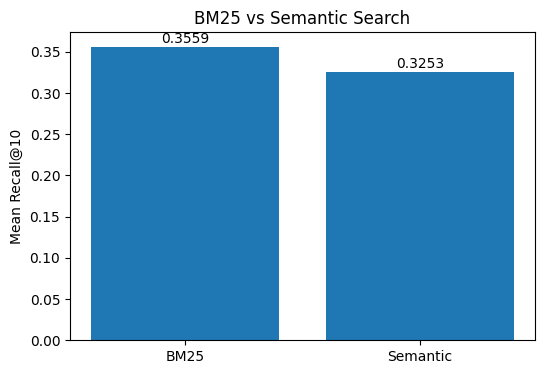

In [56]:
# Visualize comparison
summary = pd.DataFrame({
    'method': ['BM25', 'Semantic'],
    'mean_recall@10': [bm25_eval['recall'].mean(), semantic_eval['recall'].mean()]
})

plt.figure(figsize=(6,4))
plt.bar(summary['method'], summary['mean_recall@10'])
plt.ylabel('Mean Recall@10')
plt.title('BM25 vs Semantic Search')

for i, v in enumerate(summary['mean_recall@10']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha = 'center')
plt.show()

---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [57]:
# Load the two embedding models
model_bge = SentenceTransformer('BAAI/bge-base-en-v1.5')
model_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 918.80it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 838.42it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [58]:
# Embed products with both models
embs_product_bge = model_bge.encode(product_sample['combined_text'].tolist(), convert_to_numpy = True)
embs_product_mpnet = model_mpnet.encode(product_sample['combined_text'].tolist(), convert_to_numpy = True)

### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [82]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table"]
# add more!
valid_queries = queries['query']
test_queries = [q for q in test_queries if q in valid_queries]
test_queries.extend(valid_queries[:50])

test_queries_df = queries[queries['query'].isin(test_queries)] 


sample_product_ids = set(product_sample['product_id'])
sample_labels = labels[labels['product_id'].isin(sample_product_ids)]
sample_query_ids = set(sample_labels['query_id'])
sample_queries = test_queries_df[test_queries_df['query_id'].isin(sample_query_ids)]

print('Evaluation for BGE model:\n')
semantic_eval_bge = evaluate_search(
    lambda q: semantic_search(q, model_bge, embs_product_bge, product_sample, k = 10),
    sample_queries, sample_labels, k=10
)

print('=' * 40)
print('Evaluation for MPNET model:\n')
semantic_eval_mpnet = evaluate_search(
    lambda q: semantic_search(q, model_mpnet, embs_product_mpnet, product_sample, k = 10),
    sample_queries, sample_labels, k=10
)

Evaluation for BGE model:

Evaluated 49 queries
Mean Recall@10: 0.2436
Evaluation for MPNET model:

Evaluated 49 queries
Mean Recall@10: 0.2694


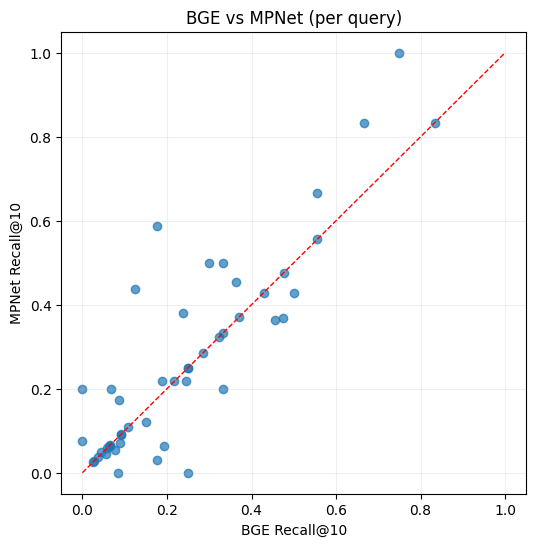

In [83]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10

x = semantic_eval_bge['recall'].to_numpy()
y = semantic_eval_mpnet['recall'].to_numpy()

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.7)

m = max(x.max(), y.max())
plt.plot([0, m], [0, m], "r--", linewidth=1)

plt.xlabel("BGE Recall@10")
plt.ylabel("MPNet Recall@10")
plt.title("BGE vs MPNet (per query)")
plt.grid(alpha=0.2)
plt.show()

---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.